In [5]:
import sys
sys.path.append('../src')

from data.decompress import decompress_yelp_data
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
import seaborn as sns

import pyarrow.json as paj


# 1. Pobranie i dekompresja danych

Pobierz ręcznie plik ZIP z danymi Yelp z [tej strony](https://business.yelp.com/external-assets/files/Yelp-JSON.zip) i zapisz go w katalogu `data/raw/`.

In [5]:
decompress_yelp_data(output_dir="../data/raw")

Checking if Yelp data already exists...
Found zip file at ../data/raw/Yelp-JSON.zip.
Extracting ZIP archive...
Extracting TAR archive...
TAR file extracted successfully.
Data has been extracted to /Users/piotrjurczyk/Documents/DS/PPD/PPD-project/data/raw


## 2. EDA

- "Przeprowadzić wstępną eksplorację danych (np. liczba przykładów, rozkład klas)."

In [ ]:
df = pd.read_json("../data/raw/Yelp JSON/yelp_dataset/yelp_academic_dataset_review.json", lines=True)

#pyarrow engine dla apple arm
#df = pd.read_json("../data/raw/Yelp JSON/yelp_dataset/yelp_academic_dataset_review.json",lines=True, engine="pyarrow")

print(f"Number of reviews: {len(df)}")

Number of reviews: 6990280


In [7]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype        
---  ------       -----        
 0   review_id    object       
 1   user_id      object       
 2   business_id  object       
 3   stars        float64      
 4   useful       int64        
 5   funny        int64        
 6   cool         int64        
 7   text         object       
 8   date         datetime64[s]
dtypes: datetime64[s](1), float64(1), int64(3), object(4)
memory usage: 480.0+ MB


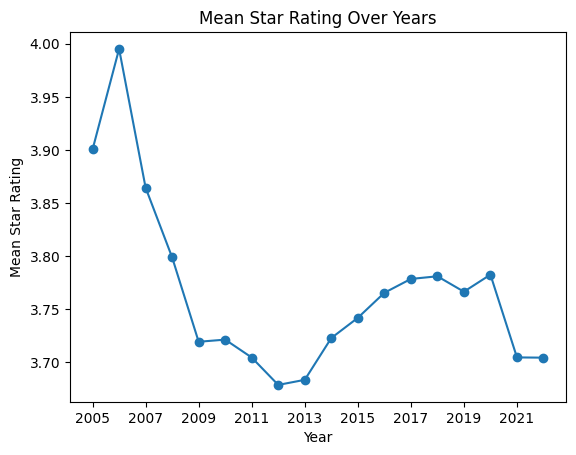

In [15]:
df['date'] = pd.to_datetime(df['date'])
df.groupby(df['date'].dt.year)['stars'].mean().plot(marker='o')
plt.title('Mean Star Rating Over Years')
plt.xlabel('Year')
plt.ylabel('Mean Star Rating')
plt.xticks(range(2005, 2023, 2))
plt.show()
plt.show()

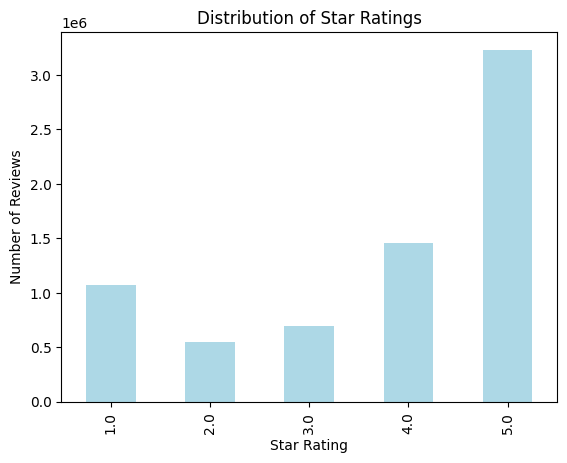

In [17]:
df['stars'].value_counts().sort_index().plot(kind='bar', color='lightblue')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.show()

In [10]:
df['text_length'] = df['text'].str.count(' ') + 1

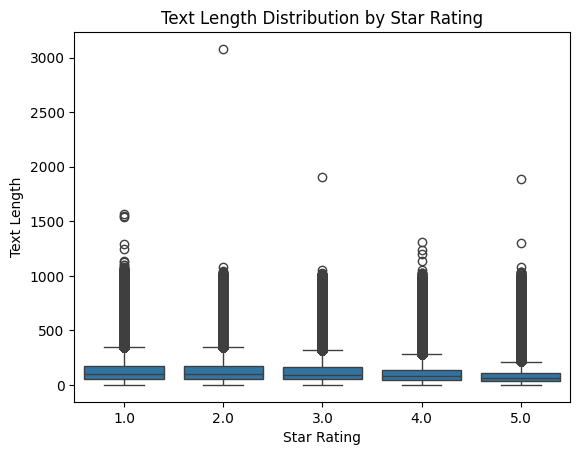

In [11]:
sns.boxplot(x='stars', y='text_length', data=df)
plt.title('Text Length Distribution by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Text Length')
plt.show()

In [12]:
df['text_length'].describe().round(2)

count    6990280.00
mean         105.80
std           98.75
min            1.00
25%           42.00
50%           76.00
75%          135.00
max         3079.00
Name: text_length, dtype: float64

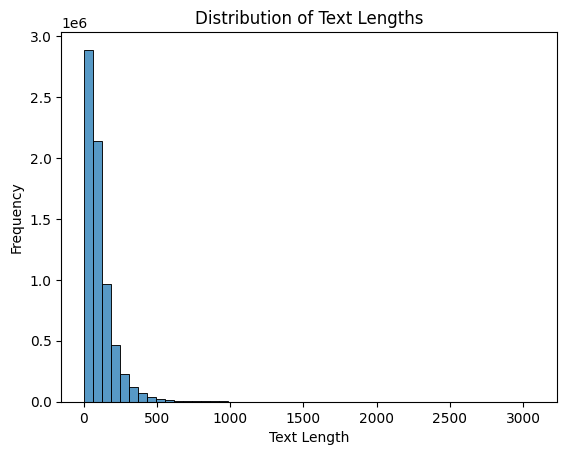

In [14]:
sns.histplot(df['text_length'], bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# 3. Przygotowanie splitu

- ""Podział danych: ~20 000 przykładów (train), 2 000 (val), 5 000 (test). Stratyfikacja przy klasyfikacji. Balans klas (down/up-sampling)."
- "Minimalny preprocessing: usunięcie duplikatów, czyszczenie HTML/URL. Ucinamy ekstremalnie długie teksty (≤512–1024 tokenów)."
- "Usunięcie braków danych."

In [5]:
# TODO